In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from model import Company, StockLog, PerformanceLog
from model import start_engine

In [3]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
engine = start_engine()

In [6]:
company = Company().query().get('ABC')

In [7]:
stock_logs = StockLog().query().filter(StockLog.company==company).order_by(StockLog.date)

In [8]:
df = pd.read_sql(stock_logs.statement, engine)

In [9]:
df.head()

,date,code,opening,high,low,closing,adjusted,volume,prediction,sma,ema,per,rank,cap
0,2000-01-03,ABC,0.71,0.71,0.68,0.68,0.28,121466,None,None,None,None,None,None
1,2000-01-04,ABC,0.68,0.70,0.68,0.70,0.29,150276,None,None,None,None,None,None
2,2000-01-05,ABC,0.68,0.69,0.67,0.68,0.28,303203,None,None,None,None,None,None
3,2000-01-06,ABC,0.68,0.68,0.67,0.67,0.27,358754,None,None,None,None,None,None
4,2000-01-09,ABC,0.66,0.67,0.66,0.67,0.27,265345,None,None,None,None,None,None


In [10]:
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

In [11]:
for i in range(0, len(df)):
    new_data['Date'][i] = df['date'][i]
    new_data['Close'][i] = df['closing'][i]

In [12]:
new_data.index = new_data.Date

In [13]:
new_data.drop('Date', axis=1, inplace=True)

In [14]:
dataset = new_data.values

In [15]:
train = dataset[0:4000,:]
valid = dataset[4000:,:]

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/usr/local/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
x_train, y_train = [], []

In [18]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=30, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 24s - loss: 0.0049


In [22]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [23]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [25]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.20590124856944966

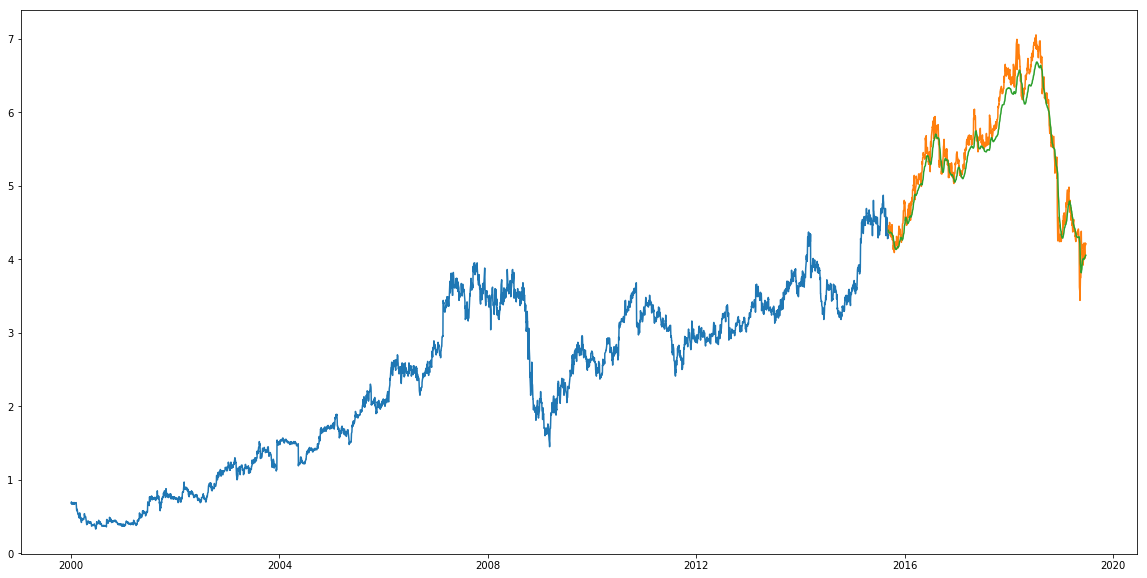

In [26]:
train = new_data[:4000]
valid = new_data[4000:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10)) 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

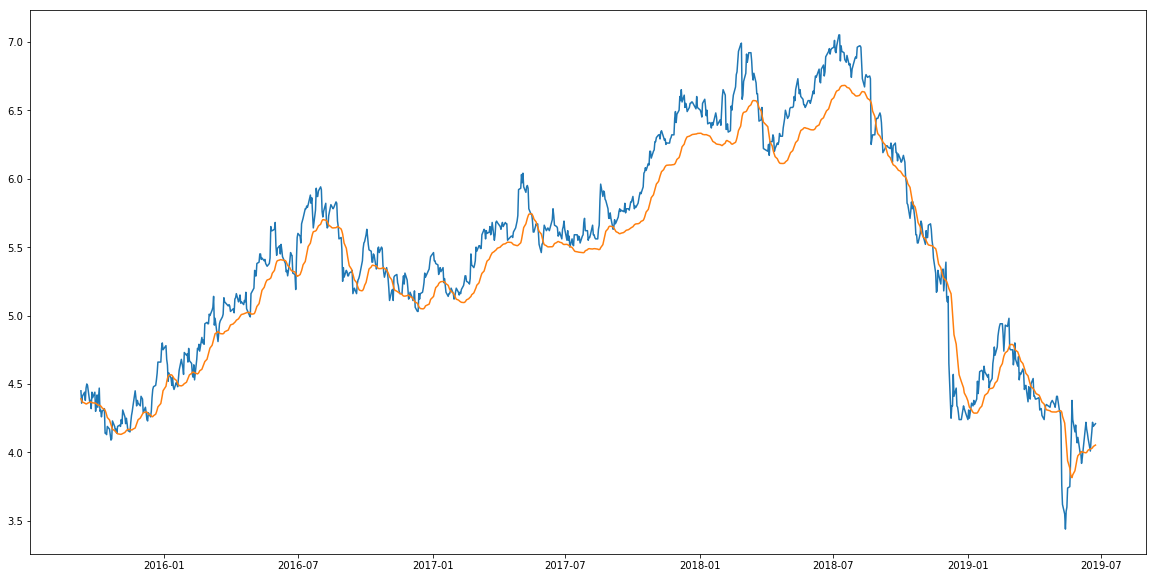

In [106]:
plt.figure(figsize=(20,10))
plt.plot(valid[['Close', 'Predictions']])
plt.savefig('shift.png')

In [62]:
perf_logs = PerformanceLog().query().filter().order_by(PerformanceLog.date)

In [80]:
df2 = pd.read_sql(perf_logs.statement, engine)

In [81]:
df2 = df2.iloc[:, :79]

In [82]:
corr = df2.corr()

In [ ]:
#f, ax = plt.subplots(figsize=(50,50))
#sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#sns.clustermap(corr, cmap='coolwarm', standard_scale=1)
plot = sns.clustermap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, figsize=(30, 30))
plot.savefig("clustermap.png")
plt.show()

In [124]:
df2 = pd.read_sql(perf_logs.statement, engine)
df2 = df2.iloc[:, :79]

In [ ]:
plot = sns.pairplot(df2)
plot.savefig("pairplot.png")
plt.show()